# Exploratory Data Analysis

### TL;DR  
- **Text fields excluded**: Free-text fields will not be considered due to challenges in processing multilingual content, varying alphabets, and emojis, which require a separate study.  
- **Followers distribution**: The log-transformed number of followers follows an approximately normal distribution, with a slight deviation suggesting at least two overlapping distributions. The number of followers and accounts followed appear uncorrelated, as expected.  
- **Unusual follower spikes**: While the distribution follows an exponential pattern beyond 1000 followers, an unexpected spike is observed between 7000 and 8000 followers, comparable to the number of accounts with around 1500 followers.  
- **Handling missing follower data**: The `NB_FOLLOWERS` column in `MART_AUTHORS` follows the same statistical pattern as `MART_AUTHORS_SEGMENTATIONS`. Therefore, null values in `MART_AUTHORS` can be filled with values from `MART_AUTHORS_SEGMENTATIONS`, if available. Remaining null values will be removed, while missing `NB_FOLLOWS` values will be replaced with the median. The `MART_AUTHORS` table is prioritized as the primary reference due to its cleaner and more reliable nature. The "fashion forward" flag (`FASHION_INTEREST_SEGMENT`) will be pulled from `MART_AUTHORS_SEGMENTATIONS`.  
- **Fashion-forward accounts**: These accounts tend to have, on average, a higher number of followers compared to standard accounts.
- **Image labels**: The table results from a two-step image recognition process, including object coordinates that will be omitted as they are irrelevant to segmentation. Some labels, such as clothing items (`top`, `shoes`, `dress`, etc.) and accessories (`earrings`, `hat`, `bag`, etc.), are particularly relevant to the business.  
- **Posting trends**: The number of posts per month remained stable in 2023 but has been declining since early 2024.  
- **Log Distributions**: Exploiting the log distribution of `NB_FOLLOWERS`, average `NB_LIKES` and average `COMMENTS_COUNT` will be easier than their original distribution.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from snowflake_utils import get_connector, query

conn = get_connector()

# Authors

In [2]:
authors_df = query(conn, "SELECT AUTHORID, NB_FOLLOWERS, NB_FOLLOWS FROM MART_AUTHORS")
authors_df.shape

(22439, 3)

In [3]:
authors_df.head(10)

,AUTHORID,NB_FOLLOWERS,NB_FOLLOWS
0,10143322655,823.0,499.0
1,56473539956,1665.0,266.0
2,188942332,283648.0,980.0
3,1428217699,491.0,1119.0
4,28688047726,8735.0,174.0
5,5619257030,550.0,590.0
6,4394381909,987.0,986.0
7,12863729971,7027.0,191.0
8,460097449,956.0,5238.0
9,2538959969,2378.0,1035.0


In [4]:
authors_df.dtypes

AUTHORID          int64
NB_FOLLOWERS    float64
NB_FOLLOWS      float64
dtype: object

In [5]:
authors_df.AUTHORID.is_unique

False

In [6]:
duplicated_authorsid_df = authors_df[authors_df.AUTHORID.duplicated()]
print('shape', duplicated_authorsid_df.shape)
duplicated_authorsid_df

shape (11, 3)


,AUTHORID,NB_FOLLOWERS,NB_FOLLOWS
1222,5921,NaN,NaN
4825,5921,NaN,NaN
5086,5921,NaN,NaN
6923,5921,5687047.0,NaN
11493,5921,NaN,NaN
13265,5921,110.0,NaN
15909,5921,NaN,NaN
16897,5921,NaN,NaN
20554,5921,NaN,NaN
21943,5921,NaN,NaN


Not much of duplicated `AUTHORID`, its safe to ignore them. 

In [7]:
authors_df.drop(index=duplicated_authorsid_df.index, inplace=True)

In [8]:
authors_df.AUTHORID.is_unique

True

Sorted, we have a unicity on `AUTHORSID`. Lets have a look at null values and potential numeric type problems:

In [9]:
print('Authors new shape', authors_df.shape)
authors_df.isnull().sum()

Authors new shape (22428, 3)


AUTHORID           0
NB_FOLLOWERS     335
NB_FOLLOWS      1073
dtype: int64

In [10]:
def test_int(df, column_name): 
    not_passing_df = df[(~df[column_name].isnull()) & (df[column_name].apply(lambda x: not x.is_integer()))]
    return not_passing_df

test_int(authors_df, 'NB_FOLLOWERS')

,AUTHORID,NB_FOLLOWERS,NB_FOLLOWS


In [11]:
test_int(authors_df, 'NB_FOLLOWS')

,AUTHORID,NB_FOLLOWERS,NB_FOLLOWS


Appart from null values, followers and follows metrics are all integers

NB_FOLLOWERS have 335 / 22428 ~ 1.49% of null values.  
NB_FOLLOWS have  1073 / 22428 ~ 4.78% of null values.

### Numeric Distributions

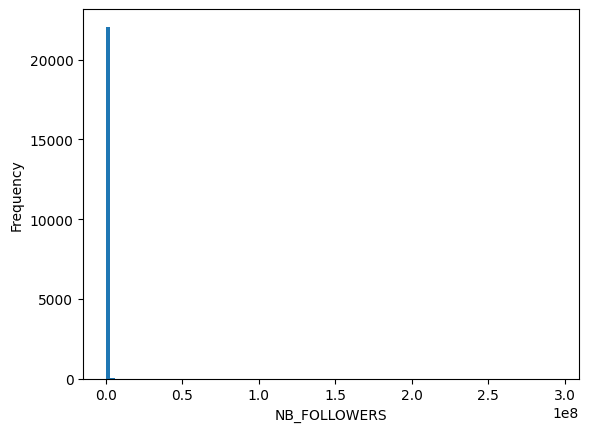

In [12]:
authors_df.NB_FOLLOWERS.plot(kind='hist', bins=100) # does not plot null values
plt.xlabel('NB_FOLLOWERS')
plt.show()

As expected, the graph is heavily influenced by extreme values, with the majority of users having significantly fewer followers in comparison. To mitigate this effect and better visualize the distribution of follower counts, we will apply a logarithmic transformation.

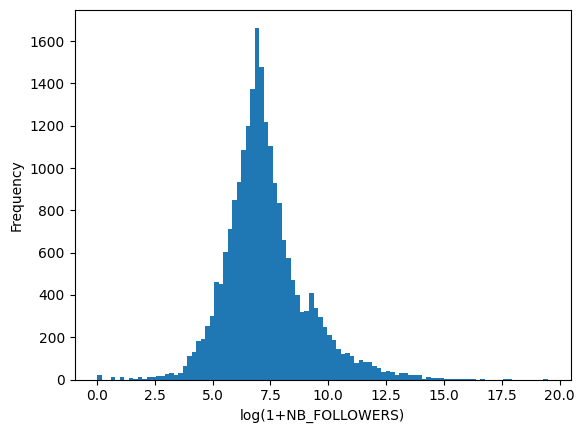

In [13]:
authors_df.NB_FOLLOWERS.apply(lambda x: np.log1p(x)).plot(kind='hist', bins=100)
plt.xlabel('log(1+NB_FOLLOWERS)')
plt.show()

The logarithm of the number of followers follows an approximately normal distribution. However, a slight bump at the beginning of the right tail suggests the presence of at least two overlapping normal distributions.

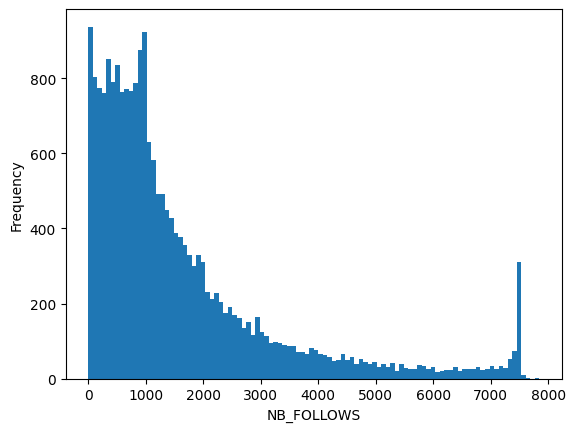

In [14]:
authors_df.NB_FOLLOWS.plot(kind='hist', bins=100)
plt.xlabel('NB_FOLLOWS')
plt.show()

Between 0 and 1000 followers, the distribution appears relatively uniform before transitioning into an exponential pattern. Interestingly, there is an unexpected spike in the number of accounts with 7000 to 8000 followers, reaching a level comparable to the number of accounts around 1500 followers.

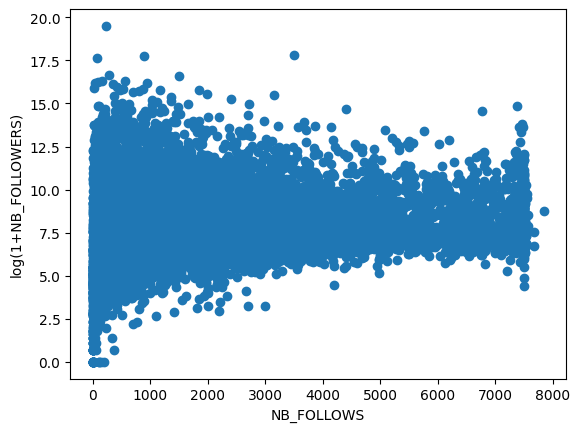

In [15]:
data = authors_df[authors_df.loc[:, ['NB_FOLLOWERS', 'NB_FOLLOWS']].notnull()]
plt.scatter(x=data.NB_FOLLOWS, y=data.NB_FOLLOWERS.apply(lambda x: np.log1p(x)))
plt.xlabel('NB_FOLLOWS')
plt.ylabel('log(1+NB_FOLLOWERS)')
plt.show()

The number of followers and the number of accounts followed appear to have no clear relationship, which aligns with expectations.

## Authors segmentations

In [16]:
authors_segmentations_df = query(conn, "SELECT * FROM MART_AUTHORS_SEGMENTATIONS")
print('shape', authors_segmentations_df.shape)
authors_segmentations_df.head(10)

shape (32841, 4)


,AUTHORID,GEO_ZONE,NB_FOLLOWERS,FASHION_INTEREST_SEGMENT
0,223985230,us,2286.111111,False
1,1430076453,us,1415.000000,False
2,9432419,us,34074.000000,False
3,23800866,us,868.000000,False
4,6809351470,us,4466.000000,False
5,10966628705,us,5603.000000,False
6,25499368,us,1211.000000,False
7,16327566221,us,902.000000,False
8,68715744751,us,117.000000,False
9,37764077070,us,50345.000000,False


In [17]:
authors_segmentations_df.dtypes

AUTHORID                      int64
GEO_ZONE                     object
NB_FOLLOWERS                float64
FASHION_INTEREST_SEGMENT       bool
dtype: object

In [18]:
authors_segmentations_df.AUTHORID.is_unique

True

The number of authors in this table exceeds that of the authors table by 10,000. Additionally, there are no duplicate values in the `AUTHORID` column.

In [19]:
authors_segmentations_df.isnull().sum()

AUTHORID                       0
GEO_ZONE                       0
NB_FOLLOWERS                1218
FASHION_INTEREST_SEGMENT       0
dtype: int64

Only 1228 / 32841 ~ 3.74% of null values in NB_FOLLOWERS, bigger ratio than in `MART_AUTHORS`

In [20]:
authors_segmentations_df.GEO_ZONE.value_counts()

GEO_ZONE
us    32841
Name: count, dtype: int64

This column contains only a single unique value and is therefore not necessary for this analysis.

In [21]:
authors_segmentations_df.drop(columns=['GEO_ZONE'], inplace=True)

In [22]:
authors_segmentations_df.FASHION_INTEREST_SEGMENT.mean()

np.float64(0.008708626412106818)

0.87 % of authors are "fashion-forward"

In [23]:
authors_segmentations_df[authors_segmentations_df.NB_FOLLOWERS.notnull()].FASHION_INTEREST_SEGMENT.mean()

np.float64(0.00904405021661449)

Excluding authors with null `NB_FOLLOWERS`, the ratio of "fashion-forward" authors is increasing at 0.90%

In [24]:
test_int(authors_segmentations_df, 'NB_FOLLOWERS')

,AUTHORID,NB_FOLLOWERS,FASHION_INTEREST_SEGMENT
0,223985230,2286.111111,False
14,50233108041,1823.600000,False
19,1830481164,21239.500000,False
27,47351790922,4011.500000,False
33,3262506049,436.333333,False
...,...,...,...
32732,6234866927,404.400000,False
32746,183420174,11222.500000,False
32752,495244981,274.750000,False
32824,11164730649,750.160714,False


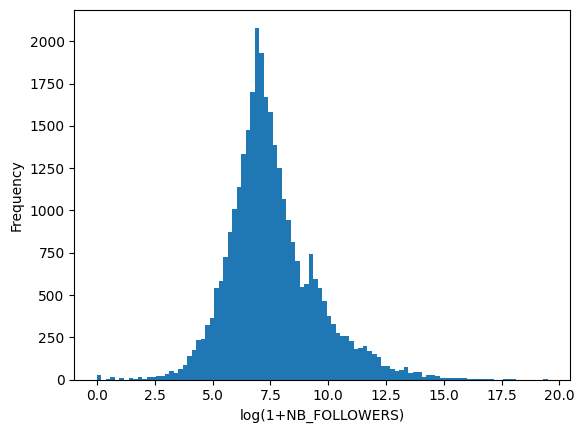

In [25]:
authors_segmentations_df[authors_segmentations_df.NB_FOLLOWERS.notnull()].NB_FOLLOWERS.apply(lambda x: np.log1p(x)).plot(kind='hist', bins=100)
plt.xlabel('log(1+NB_FOLLOWERS)')
plt.show()

The distribution of the number of followers (`NB_FOLLOWERS`) appears to follow the same statistical pattern as in the `MART_AUTHORS` table. Based on this observation, it seems reasonable to populate the `NB_FOLLOWERS` null values in `MART_AUTHORS` with corresponding values from `MART_AUTHORS_SEGMENTATIONS`, if available.

Although the `MART_AUTHORS` table contains fewer authors than `MART_AUTHORS_SEGMENTATIONS`, I feel more confident using `MART_AUTHORS` as the primary reference for further discussions and analysis, as it appears to be the source table. Therefore, we will prioritize using `NB_FOLLOWERS` from `MART_AUTHORS` due to its cleaner and more reliable nature. However, I would suggest pulling the "fashion forward" flag (`FASHION_INTEREST_SEGMENT`) from `MART_AUTHORS_SEGMENTATIONS`.

For the remaining authors with null values in `NB_FOLLOWERS`, we can remove them from the analysis. Lastly, any remaining null values for `NB_FOLLOWS` can be filled with the median value to ensure consistency in the dataset.

In [26]:
from queries import clean_authors_query

authors_df = query(conn, clean_authors_query)
print('shape', authors_df.shape)
authors_df.head()

shape (22268, 5)


,AUTHORID,NB_FOLLOWS,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,FASHION_INTEREST_SEGMENT
0,323798338,1100,640,6.463029,False
1,49781027964,1,58,4.077537,False
2,1683100126,2919,7184,8.879751,False
3,1455851258,6553,2973,7.997663,False
4,27709749,4547,16509,9.711722,False


In [27]:
authors_df.dtypes

AUTHORID                      int64
NB_FOLLOWS                    int16
NB_FOLLOWERS                  int32
NB_FOLLOWERS_LN1P           float64
FASHION_INTEREST_SEGMENT       bool
dtype: object

In [28]:
authors_df.isnull().sum()

AUTHORID                    0
NB_FOLLOWS                  0
NB_FOLLOWERS                0
NB_FOLLOWERS_LN1P           0
FASHION_INTEREST_SEGMENT    0
dtype: int64

In [29]:
authors_df.FASHION_INTEREST_SEGMENT.value_counts()

FASHION_INTEREST_SEGMENT
False    21982
True       286
Name: count, dtype: int64

Boosting the ratio "fashion-forward" ratio vs rest of the world from 0.9% to 1.28%  

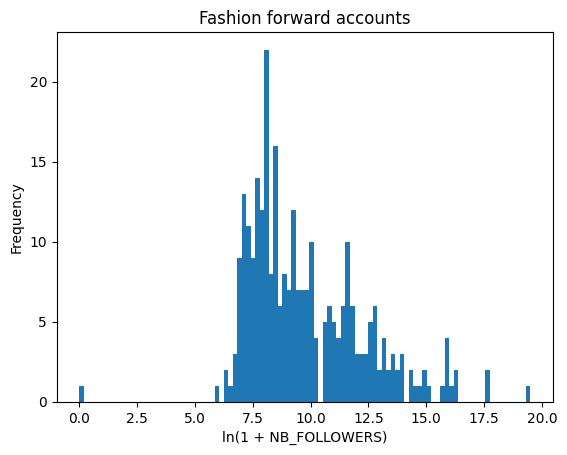

In [30]:
authors_df[authors_df.FASHION_INTEREST_SEGMENT].NB_FOLLOWERS_LN1P.plot(kind='hist', bins=100)
plt.xlabel('ln(1 + NB_FOLLOWERS)')
plt.title('Fashion forward accounts')
plt.show()

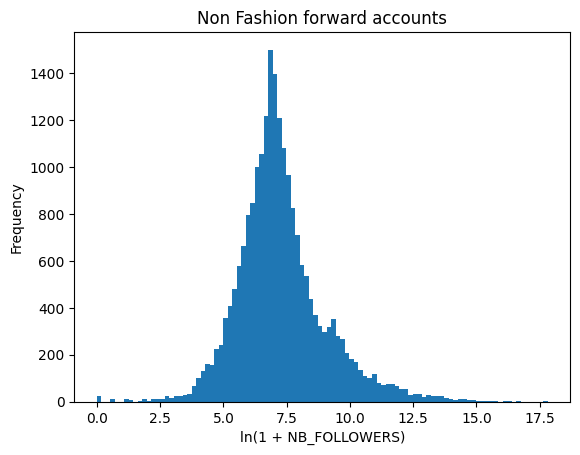

In [31]:
authors_df[~authors_df.FASHION_INTEREST_SEGMENT].NB_FOLLOWERS_LN1P.plot(kind='hist', bins=100)
plt.xlabel('ln(1 + NB_FOLLOWERS)')
plt.title('Non Fashion forward accounts')
plt.show()

Fashion-forward accounts tend to have, on average, a higher number of followers compared to standard accounts.

## Images Labels

This table is the result of a two-step image recognition process and includes a column formatted as an array of four numbers, representing the position of the detected object within the image. As these coordinates are primarily used for localization rather than offering meaningful insights for our segmentation task, we will omit this feature from our analysis.

In [32]:
images_labels = query(conn, 
"""
SELECT IMAGE_ID, TYPE, LABEL_NAME FROM MART_IMAGES_LABELS
"""
)

In [33]:
print('shape', images_labels.shape)
images_labels.head(10)

shape (17895852, 3)


,IMAGE_ID,TYPE,LABEL_NAME
0,7a244b3631f5a38b1eb456f97d48447c,shoe,toeround
1,7a244b3631f5a38b1eb456f97d48447c,shoe,sandals
2,7a244b3631f5a38b1eb456f97d48447c,shoe,sandalsclassicstraps
3,7a244b3631f5a38b1eb456f97d48447c,shoe,toeround
4,7a244b3631f5a38b1eb456f97d48447c,shoe,sandals
5,7a244b3631f5a38b1eb456f97d48447c,shoe,closurebuckle
6,768b32b1f4c1233eb0ddc9298c752377,shoe,sneakerssockpullon
7,768b32b1f4c1233eb0ddc9298c752377,shoe,solerubber
8,768b32b1f4c1233eb0ddc9298c752377,shoe,closedback
9,768b32b1f4c1233eb0ddc9298c752377,shoe,noheel


In [34]:
images_labels.dtypes

IMAGE_ID      object
TYPE          object
LABEL_NAME    object
dtype: object

In [35]:
images_labels.isnull().sum()

IMAGE_ID      0
TYPE          0
LABEL_NAME    0
dtype: int64

In [36]:
images_labels.duplicated().sum() > 0

np.True_

This table contains duplicate rows, lets remove them. 

In [37]:
images_labels_deduplicated = images_labels.drop_duplicates()

In [38]:
images_labels_deduplicated.shape

(10372903, 3)

Deduplication reduced the dataset size to approximately 58% of its original volume (10372903 rows from 17895852).

In [39]:
images_labels_deduplicated.IMAGE_ID.drop_duplicates().count()

np.int64(1964877)

1964877 unique Images

In [40]:
images_types = images_labels_deduplicated[['IMAGE_ID', 'TYPE']].drop_duplicates()
print('shape', images_types.shape)

shape (2995227, 2)


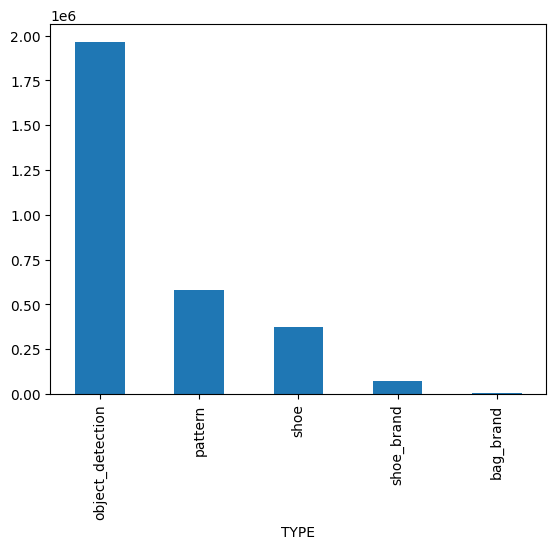

In [41]:
images_types.TYPE.value_counts().plot(kind='bar')
plt.show()

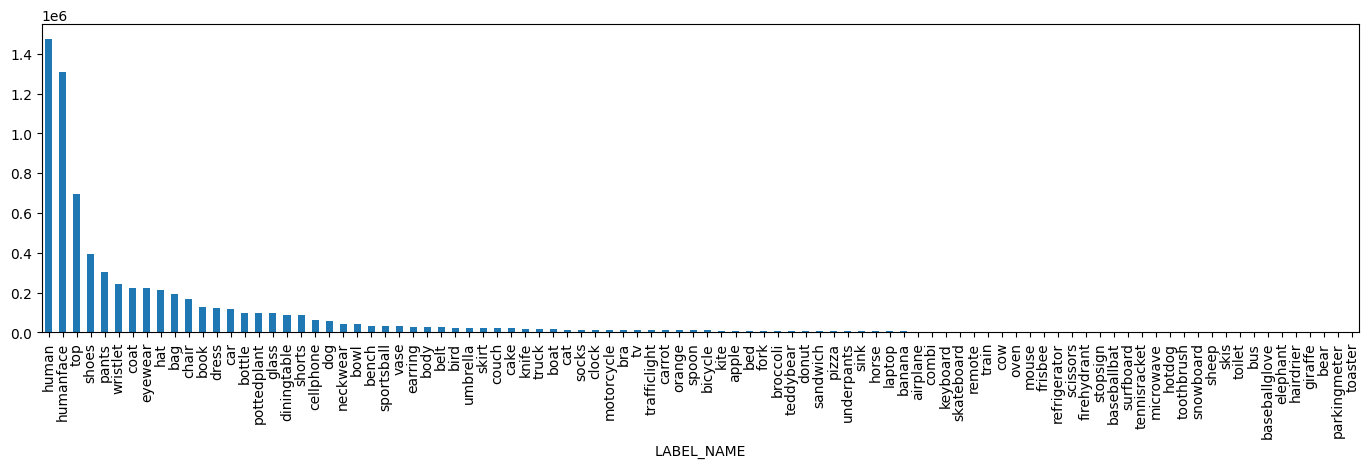

In [42]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'object_detection'].LABEL_NAME.value_counts().plot(kind='bar', figsize=(17, 4))
plt.show()

In [43]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'object_detection'].LABEL_NAME.unique()

array(['human', 'cellphone', 'eyewear', 'bag', 'neckwear', 'dog', 'top',
       'humanface', 'coat', 'wristlet', 'pants', 'glass', 'pottedplant',
       'bus', 'carrot', 'hat', 'dress', 'book', 'shoes', 'shorts', 'bed',
       'socks', 'belt', 'bench', 'fork', 'spoon', 'knife', 'cake',
       'sportsball', 'earring', 'diningtable', 'chair', 'car', 'clock',
       'bowl', 'firehydrant', 'remote', 'horse', 'couch', 'bottle',
       'motorcycle', 'keyboard', 'bicycle', 'umbrella', 'vase', 'truck',
       'body', 'bra', 'snowboard', 'underpants', 'orange', 'skirt',
       'bird', 'sandwich', 'boat', 'tv', 'cat', 'airplane', 'kite',
       'broccoli', 'pizza', 'combi', 'trafficlight', 'train',
       'skateboard', 'giraffe', 'laptop', 'baseballbat', 'microwave',
       'teddybear', 'donut', 'apple', 'skis', 'sink', 'banana',
       'scissors', 'frisbee', 'refrigerator', 'toilet', 'surfboard',
       'bear', 'stopsign', 'hotdog', 'cow', 'oven', 'tennisracket',
       'mouse', 'elephant', 'sh

A few labels may be particularly relevant to the business. For example:
- **Clothing items**: `top`, `shoes`, `pants`, `coats`, `skirt`, `dress`, `shorts`, `socks`, `combi`, `bra`, `underpants`
- **Accessories**: `earrings`, `clock`, `hat`, `neckwear`, `eyewear`, `wristlet`, `bag`, `belt`, `umbrella`

The definition of accessories can vary depending on how fashion is perceived as a whole, certain items could be considered accessories in specific contexts (eg. `stopsign`), but I have kept the categorization simple and aligned with mainstream conventions.

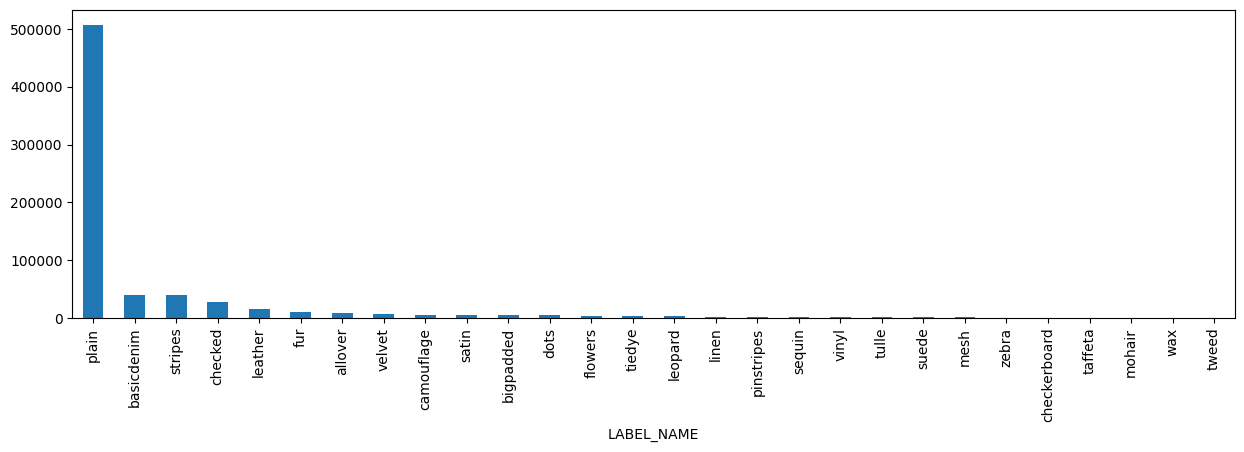

In [44]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'pattern'].LABEL_NAME.value_counts().plot(kind='bar', figsize=(15, 4))
plt.show()

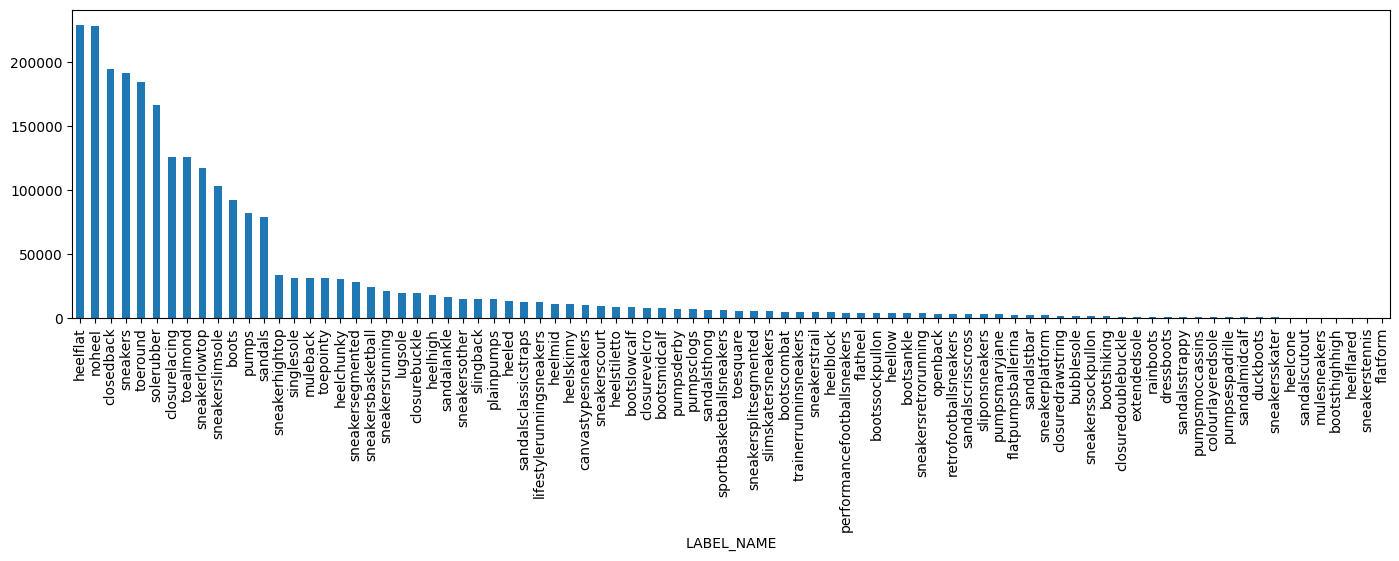

In [45]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'shoe'].LABEL_NAME.value_counts().plot(kind='bar', figsize=(17, 4))
plt.show()

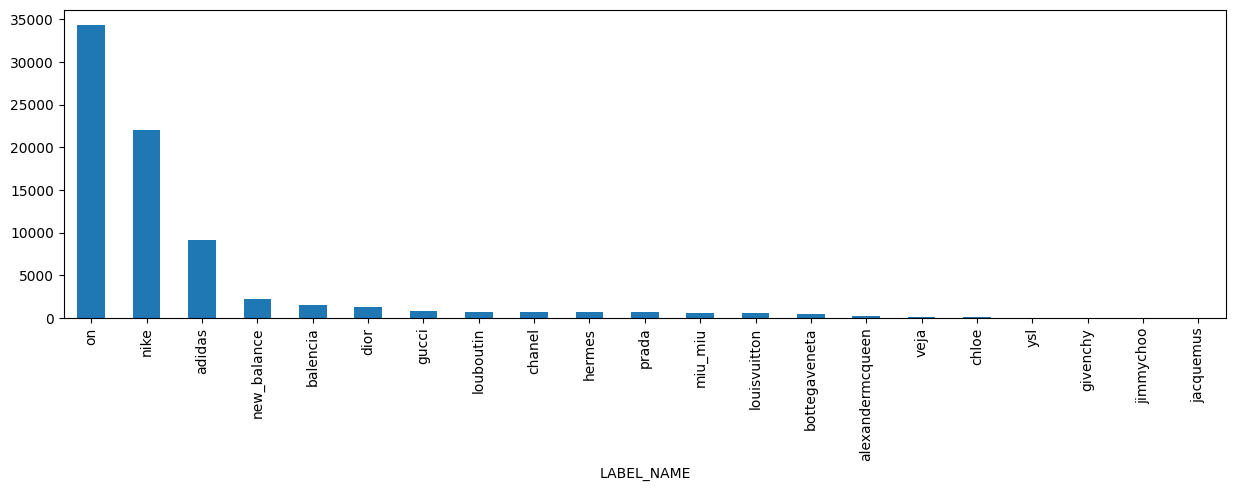

In [46]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'shoe_brand'].LABEL_NAME.value_counts().plot(kind='bar', figsize=(15, 4))
plt.show()

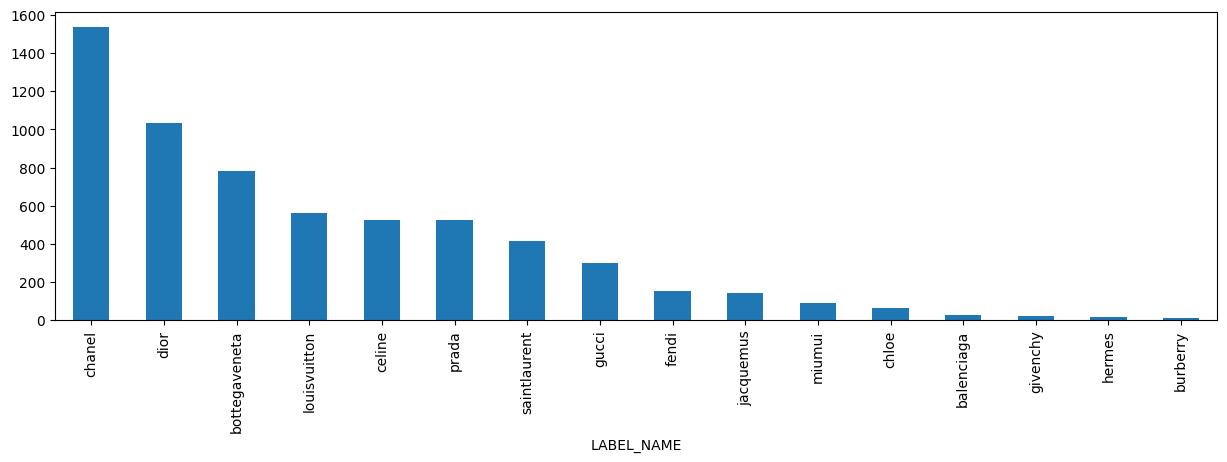

In [47]:
images_labels_deduplicated[images_labels_deduplicated.TYPE == 'bag_brand'].LABEL_NAME.value_counts().plot(kind='bar', figsize=(15, 4))
plt.show()

No cleaning seems necessary for other labels types.

In [48]:
nb_types_per_image = images_types.groupby('IMAGE_ID').count().rename(columns={'TYPE': 'NB_TYPES'})

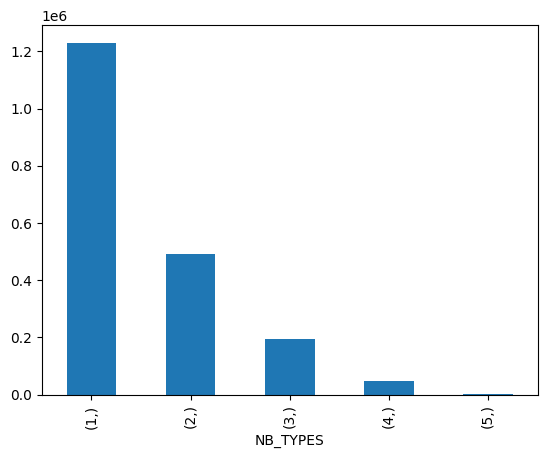

In [49]:
nb_types_per_image.value_counts().plot(kind='bar')
plt.show()

In [50]:
nb_types_per_image.mean()

NB_TYPES    1.524384
dtype: float64

In average, 1.5 types are detected per image.

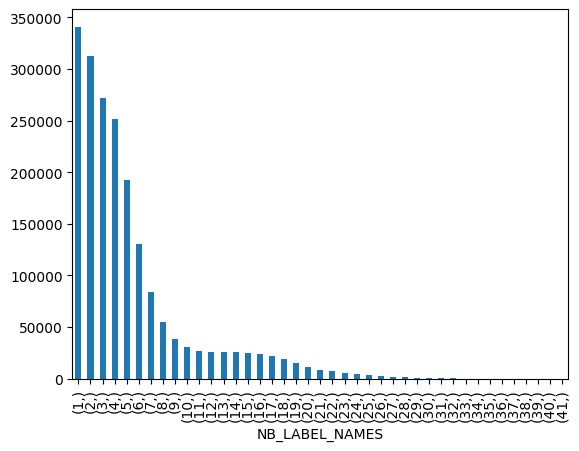

In [51]:
nb_labels_per_image = images_labels_deduplicated[['IMAGE_ID', 'LABEL_NAME']].groupby('IMAGE_ID').count().rename(columns={'LABEL_NAME': 'NB_LABEL_NAMES'})
nb_labels_per_image.value_counts().plot(kind='bar')
plt.show()

In [52]:
nb_labels_per_image.mean()

NB_LABEL_NAMES    5.279161
dtype: float64

In [53]:
import pandas as pd
dummies_images_types = pd.get_dummies(images_types, columns=['TYPE'], prefix='', prefix_sep='').groupby('IMAGE_ID').sum()
dummies_images_types.head()

,bag_brand,object_detection,pattern,shoe,shoe_brand
IMAGE_ID,,,,,
0000022bcc942116d5cc721c7bd93ae8,0,1,0,0,0
00000464ab071bb34f4e6d0dd4cd1709,0,1,0,0,0
00001ef17721693ae266c052ff475315,0,1,0,0,0
000026a1b1129b299a4bbeb543c1047a,0,1,1,0,0
000028449965a7b9909f8210b8e4ce0b,0,1,0,0,0


In [54]:
dummies_images_types.describe()

,bag_brand,object_detection,pattern,shoe,shoe_brand
count,1.964877e+06,1.964877e+06,1.964877e+06,1.964877e+06,1.964877e+06
mean,3.072966e-03,9.995155e-01,2.953874e-01,1.898129e-01,3.659517e-02
std,5.534911e-02,2.200623e-02,4.562168e-01,3.921531e-01,1.877658e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Type object_detection is activated 99.95% of the time.

In [55]:
images_types_query = """
SELECT 
    DISTINCT 
        IMAGE_ID
        , TYPE 
        , 1 AS is_type
FROM MART_IMAGES_LABELS
"""

images_labels_query = """
SELECT 
    DISTINCT
        IMAGE_ID
        , LABEL_NAME
        , 1 AS is_label
FROM MART_IMAGES_LABELS
"""

images_types_pivoted_query = f"""
SELECT *
FROM ({images_types_query}) 
PIVOT ( COUNT(is_type) FOR TYPE IN(ANY) )
"""

images_labels_pivoted_query = f"""
SELECT *
FROM ({images_labels_query}) 
PIVOT ( COUNT(is_label) FOR LABEL_NAME IN(ANY) )
"""


In [56]:
print(images_labels_pivoted_query)


SELECT *
FROM (
SELECT 
    DISTINCT
        IMAGE_ID
        , LABEL_NAME
        , 1 AS is_label
FROM MART_IMAGES_LABELS
) 
PIVOT ( COUNT(is_label) FOR LABEL_NAME IN(ANY) )



In [57]:
images_types_pivoted = query(conn, images_types_pivoted_query)
print('shape', images_types_pivoted.shape)
images_types_pivoted.head()

shape (1964877, 6)


,IMAGE_ID,'bag_brand','object_detection','pattern','shoe','shoe_brand'
0,cd292a287f6fc46f75ccb49f4aeb91ba,0,1,1,1,0
1,9bf99c990fd09acc8fe3c6fbc9f60df3,0,1,1,1,0
2,4c422e2148729a0e6e44436585f6e3b1,0,1,0,1,0
3,9c6eb08595b7ac523ac7edca0006640b,0,1,1,1,1
4,2640289fcb407d31fdd933c10ede929e,0,1,1,1,0


In [58]:
images_types_pivoted.IMAGE_ID.is_unique

True

In [59]:
images_types_pivoted.dtypes

IMAGE_ID              object
'bag_brand'            int64
'object_detection'     int64
'pattern'              int64
'shoe'                 int64
'shoe_brand'           int64
dtype: object

In [60]:
# images_labels_pivoted = query(conn, images_labels_pivoted_query)
# print('shape', images_types_pivoted.shape)
# images_types_pivoted.head()

Fetching this is crashing my device but is working on the patform in less than 30 seconds, lets see what I can do with it later.

In [61]:
# images_labels_pivoted.IMAGE_ID.is_unique

## Images of Posts

In [62]:
image_of_posts_df = query(conn,
"""
SELECT 
      POST_ID
    , AUTHORID
    , IMAGE_ID
    , NB_LIKES
    , COMMENT_COUNT
    , POST_PUBLICATION_DATE
FROM MART_IMAGES_OF_POSTS
"""
)

In [63]:
print('shape', image_of_posts_df.shape)
image_of_posts_df.head()

shape (2495320, 6)


,POST_ID,AUTHORID,IMAGE_ID,NB_LIKES,COMMENT_COUNT,POST_PUBLICATION_DATE
0,052b756cba9d8bc527cc1740a5a65e32,18420762141,86cfc0843cfe6a1c155dbbc737eec5e3,56,1,2024-07-29 16:51:43
1,65693593aa59b2a4080d5b04762de9be,35143516145,20c16b619aa9ac0c1ddee07ad02987df,81,4,2024-08-06 00:08:42
2,72134f769a3ffccc08c0014486a5513e,6743826613,5b0cfc8ab47b67bffc03bd9ca9adc3ae,0,0,2024-08-26 16:26:16
3,29ae13646c4b0b675698109b222c1de1,213043580,4e56d186f8f960d112dc2a0898083ba1,8,0,2024-08-30 02:59:18
4,6ea80baf4af212abf8757bb8537d42d4,42813255192,b3183b0df3776170127dcb728b3d9e9b,27,0,2024-08-20 13:28:29


In [64]:
image_of_posts_df.dtypes

POST_ID                         object
AUTHORID                         int64
IMAGE_ID                        object
NB_LIKES                         int32
COMMENT_COUNT                    int32
POST_PUBLICATION_DATE    datetime64[s]
dtype: object

In [65]:
image_of_posts_df.isnull().sum()

POST_ID                  0
AUTHORID                 0
IMAGE_ID                 0
NB_LIKES                 0
COMMENT_COUNT            0
POST_PUBLICATION_DATE    0
dtype: int64

In [66]:
image_of_posts_df.POST_PUBLICATION_DATE.describe()

count                2495320
mean     2023-12-19 04:24:16
min      2023-01-01 00:00:06
25%      2023-06-22 02:48:12
50%      2023-12-06 01:17:02
75%      2024-06-09 21:43:30
max      2025-01-19 23:59:05
Name: POST_PUBLICATION_DATE, dtype: object

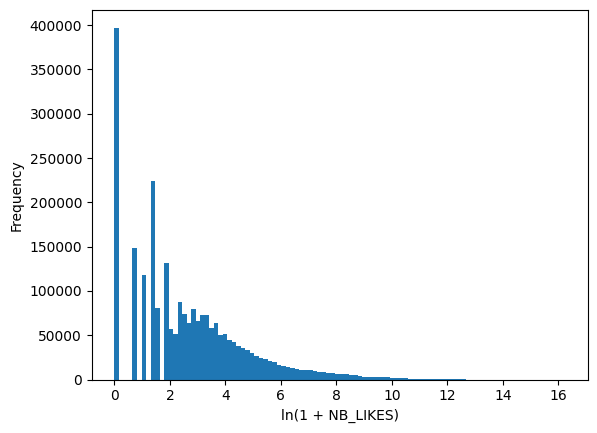

In [67]:
image_of_posts_df.NB_LIKES.apply(np.log1p).plot(kind='hist', bins=100)
plt.xlabel('ln(1 + NB_LIKES)')
plt.show()

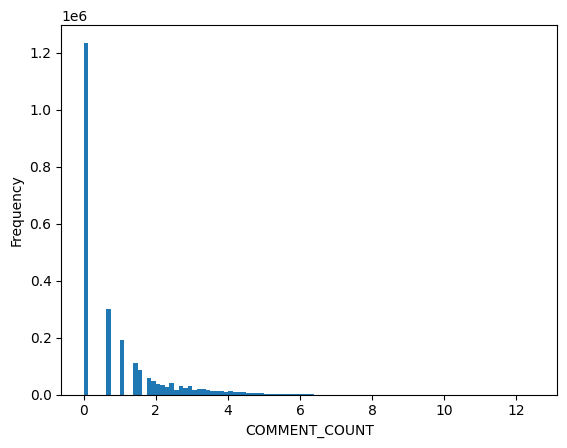

In [68]:
image_of_posts_df.COMMENT_COUNT.apply(np.log1p).plot(kind='hist', bins=100)
plt.xlabel('COMMENT_COUNT')
plt.show()

In [69]:
def get_year(datetime): 
    return datetime.year

def get_month(datetime): 
    return datetime.month

def get_year_month(datetime): 
    year = get_year(datetime)
    month = get_month(datetime)
    year_month = year*100 + month

    return year_month

image_of_posts_df['POST_PUBLICATION_YEAR'] = image_of_posts_df.POST_PUBLICATION_DATE.apply(get_year)
image_of_posts_df['POST_PUBLICATION_MONTH'] = image_of_posts_df.POST_PUBLICATION_DATE.apply(get_month)
image_of_posts_df['POST_PUBLICATION_YEAR_MONTH'] = image_of_posts_df.POST_PUBLICATION_DATE.apply(get_year_month)

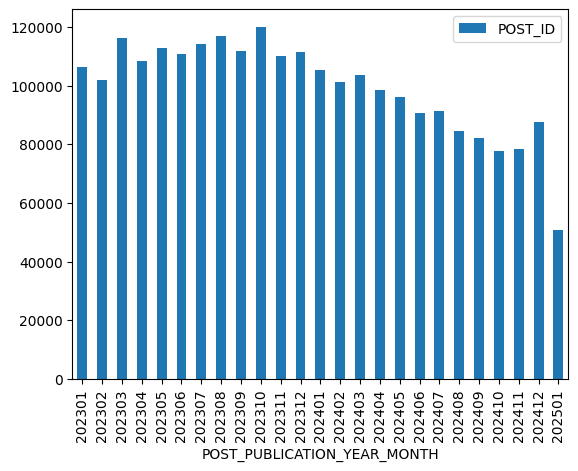

In [70]:
( 
    image_of_posts_df[['POST_ID', 'POST_PUBLICATION_YEAR_MONTH']]
    .drop_duplicates()
    .groupby('POST_PUBLICATION_YEAR_MONTH')
    .count()
    .sort_index()
).plot(kind='bar')
plt.show()

The number of posts per month remained relatively stable throughout 2023 but has been declining since the beginning of 2024.

In [71]:
authors_post_summary_df = query(conn, """
SELECT
    AUTHORID
    , CAST(AVG(NB_LIKES) AS FLOAT) AS AVG_LIKES
    , CAST(VARIANCE(NB_LIKES) AS FLOAT) AS VAR_LIKES
    , CAST(AVG(COMMENT_COUNT) AS FLOAT) AS AVG_COMMENTS
    , CAST(VARIANCE(COMMENT_COUNT) AS FLOAT) AS VAR_COMMENTS
    , COUNT(DISTINCT POST_ID) AS NB_POSTS 
    , COUNT(IMAGE_ID) AS NB_IMAGES
    , DATEDIFF(day, MIN(POST_PUBLICATION_DATE), ANY_VALUE(MAX_DATE_IN_POST_DATASET) ) AS NB_DAYS_SINCE_FIRST_PUBLICATION
FROM MART_IMAGES_OF_POSTS 
CROSS JOIN (
    SELECT 
        MAX(POST_PUBLICATION_DATE) AS MAX_DATE_IN_POST_DATASET 
    FROM MART_IMAGES_OF_POSTS
) last_date
GROUP BY AUTHORID
""")
print('shape', authors_post_summary_df.shape)
authors_post_summary_df.head()

shape (29075, 8)


,AUTHORID,AVG_LIKES,VAR_LIKES,AVG_COMMENTS,VAR_COMMENTS,NB_POSTS,NB_IMAGES,NB_DAYS_SINCE_FIRST_PUBLICATION
0,8066386079,18.439929,55.591960,0.038869,0.072823,565,566,749
1,173734954,112.311111,8562.491919,13.333333,269.545455,45,45,716
2,48141873383,4.531719,6.775840,0.546713,1.668427,867,867,749
3,416310377,15.864198,131.693827,1.172840,1.219753,81,81,749
4,11606378791,2.719682,38.034811,0.147117,0.739270,500,503,747


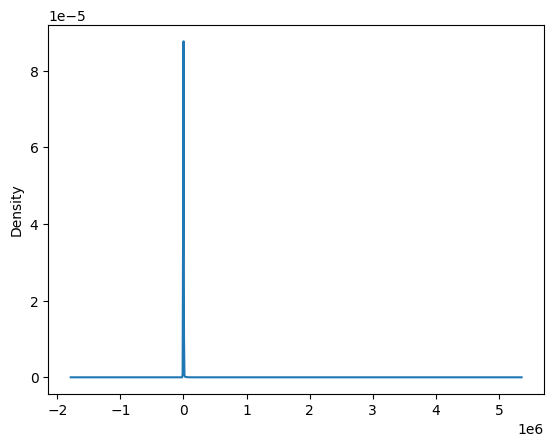

In [72]:
authors_post_summary_df.AVG_LIKES.plot(kind='kde')
plt.show()

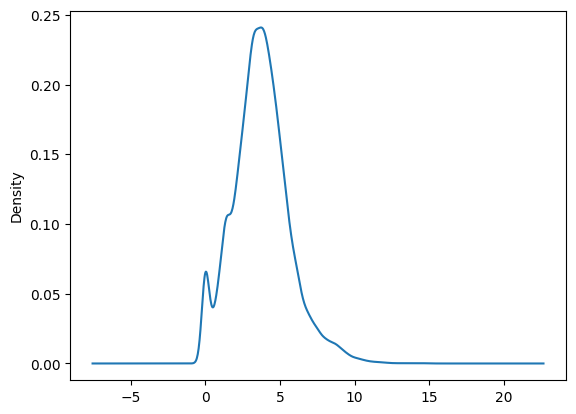

In [73]:
authors_post_summary_df.AVG_LIKES.apply(np.log1p).plot(kind='kde')
plt.show()

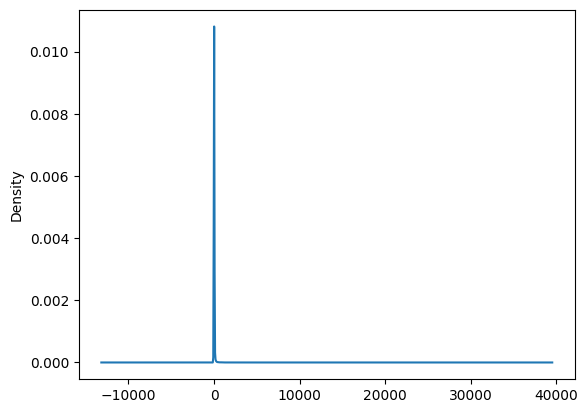

In [74]:
authors_post_summary_df.AVG_COMMENTS.plot(kind='kde')
plt.show()

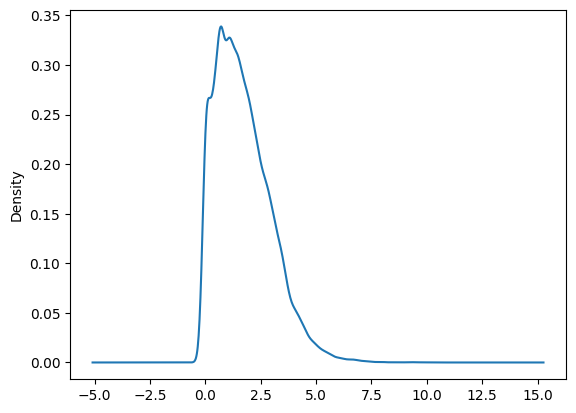

In [75]:
authors_post_summary_df.AVG_COMMENTS.apply(np.log1p).plot(kind='kde')
plt.show()

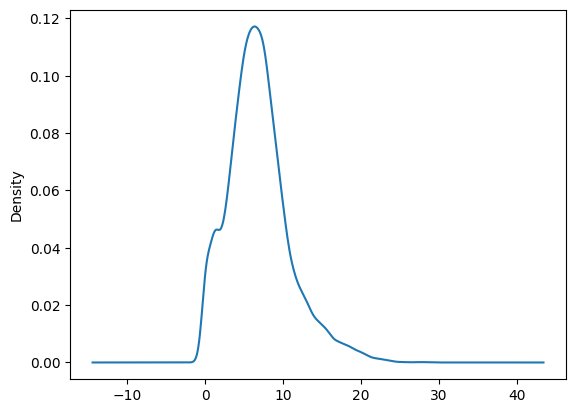

In [76]:
authors_post_summary_df.VAR_LIKES.apply(np.log1p).plot(kind='kde')
plt.show()

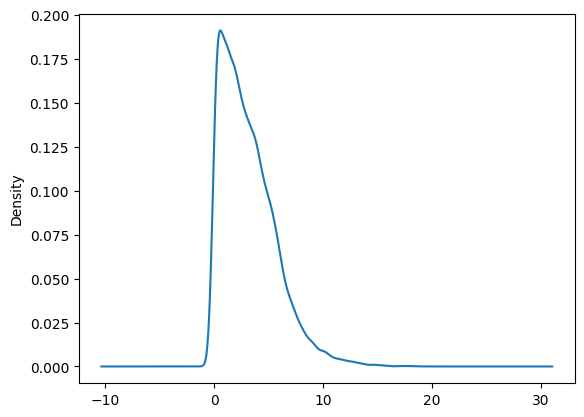

In [77]:
authors_post_summary_df.VAR_COMMENTS.apply(np.log1p).plot(kind='kde')
plt.show()

In [78]:
conn.close()